In [164]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib
import scipy.io
from Crowd_read import *
import scikitplot as skplt
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
import numpy as np
np.set_printoptions(threshold=np.inf)

In [165]:
normal_remain_scene_array = [609, 810, 475,
                             675, 624, 548,
                             862, 604, 638,
                             658, 789]
abnormal_point_scene_array = [506, 675, 329, 602, 497, 460, 746, 469, 560, 580, 711]



In [166]:
def feature_array_smoothed(feature):
    df = pd.DataFrame({"B": np.squeeze(feature)})

    b = df.rolling(window=9).mean()
    df2 = pd.DataFrame({'D': np.squeeze(b)})
    z = df2.rolling(window=9).mean()
    x = z.dropna()

    x_array = (x.values).T
    padding_data = x_array[0, 0]
    padding_list = [padding_data]*16
    padding_array = np.array(padding_list)
    padding_array = padding_array.reshape(1, padding_array.shape[0])
    x_array_padded = np.append(padding_array, x_array)
    x_array_padded= x_array_padded.reshape(1, x_array_padded.shape[0])
    x_array_padded_squeezed = np.squeeze(x_array_padded)
    return x_array_padded

In [167]:
for i in range(len(feature)):
    if i == 0:
        continue
    else:
        feature[i] = np.insert(feature[i], 0, 0)
        feature[i] = reshape_array(feature[i])
        feature_length += feature[i].shape[1]
        print(feature[i].shape[1])

print(feature_length)

for i in range(len(feature)):
    if i == 0:
        continue
    else:
        feature[i] = np.insert(feature[i], 0, 0)
        feature[i] = reshape_array(feature[i])
        feature_length += feature[i].shape[1]
        print(feature[i].shape[1])

print(feature_length)



623
824
524
690
750
570
902
659
647
667
798
76056
624
825
525
691
751
571
903
660
648
668
799
83721


In [168]:
def handleEndScene(abnormal_point, fearture_array, actual_list):
    dimension = fearture_array.shape[1]
    fearture_array_rounded = np.round(fearture_array, 3)
    finish_point = 0
    
    for j in range(abnormal_point+1,dimension):
        if fearture_array_rounded[0, j] \
                - fearture_array_rounded[0, abnormal_point-1] <= 0.002:
            finish_point = j
            print("{} is {}".format("finish_point", finish_point))
            break
    actual_handled_array = np.array(actual_list)
    if finish_point:
        actual_handled_array[finish_point+1 : ] = 0
    
    return actual_handled_array
        
        

In [169]:
def createlistzeros(n):
    a = [0]*n
    return a

In [170]:
def createlistones(n):
    a = [1]*n
    return a

In [171]:
def modified_y_test(feature_smoothed, abnormal_point, normal_remain_point):
    normal_array = createlistzeros(abnormal_point)
    if normal_remain_point >= feature_smoothed.shape[1]:
        abnormal_array = createlistones(feature_smoothed.shape[1] - abnormal_point)
        A_list = normal_array + abnormal_array
    else:
        abnormal_array = createlistones(normal_remain_point - abnormal_point)
        normal_remain_array = createlistzeros(feature_smoothed.shape[1] - normal_remain_point)
        A_list = normal_array + abnormal_array + normal_remain_array
        
    y_grass = reshape_array(np.array(A_list))
    
    return y_grass


In [172]:
def feature_normalization(feature_index_smoothed):
    feature_index_normalized = 100 * (feature_index_smoothed 
                                      - np.min(feature_index_smoothed))/\
                               (np.max(feature_index_smoothed) - np.min(feature_index_smoothed))
    
    return feature_index_normalized

In [173]:
def cross_validation(feature07_smoothed,y_grass_07, n_split_fold, n_repeats_fold):
    feature07_smoothed_squeezed = np.squeeze(feature07_smoothed)
    y_grass_07_squeezed = np.squeeze(y_grass_07)
    X_train=X_test=Y_train=Y_test = []
    kf = RepeatedKFold(n_splits = n_split_fold, n_repeats= n_repeats_fold, 
                   random_state= None)
    for train_index, test_index in kf.split(feature07_smoothed_squeezed):
# print("Train: ", train_index, "Validation", test_index)
        X_train, X_test = feature07_smoothed_squeezed[train_index], \
                      feature07_smoothed_squeezed[test_index]
        Y_train, Y_test = y_grass_07_squeezed[train_index], \
                      y_grass_07_squeezed[test_index]

    X_train = reshape_array(X_train)
    X_test = reshape_array(X_test)
    Y_train = reshape_array(Y_train)
    Y_test = reshape_array(Y_test)
    return X_train, X_test, Y_train, Y_test

In [190]:
X_grass_train_array = np.reshape(feature_smoothed[2], -1)[515:815]
X_grass_train_array = np.reshape(X_grass_train_array,(1,X_grass_train_array.shape[0]))

Y_grass_train_array = np.reshape(y_grass_02, -1)[515:815]
Y_grass_train_array = np.reshape(Y_grass_train_array, (1,Y_grass_train_array.shape[0]))


X_square_train_array = np.reshape(feature_smoothed[9], -1)[337:637]
X_square_train_array = np.reshape(X_square_train_array, (1, X_square_train_array.shape[0]))

Y_square_train_array = np.reshape(y_square_01, -1)[337:637]
Y_square_train_array = np.reshape(Y_square_train_array, (1, Y_square_train_array.shape[0]))

In [191]:
def reshape_array(array):
    array = array.reshape(1, array.shape[0])
    return array
    

In [192]:
def connect_similar_scene_together(feature01, feature02):
    grass_list = np.squeeze(feature01).tolist() + np.squeeze(feature02).tolist()
    grass_array_row = np.array(grass_list)
    grass_array = grass_array_row.reshape((1, len(grass_list)))
    return grass_array

In [193]:


y_grass_01 = modified_y_test(feature[1], abnormal_point_scene_array[0], normal_remain_scene_array[0])
y_grass_02 = modified_y_test(feature[2], abnormal_point_scene_array[1], normal_remain_scene_array[1])
y_inside_01 = modified_y_test(feature[3], abnormal_point_scene_array[2], normal_remain_scene_array[2])
y_inside_02 = modified_y_test(feature[4], abnormal_point_scene_array[3], normal_remain_scene_array[3])
y_inside_03 = modified_y_test(feature[5], abnormal_point_scene_array[4], normal_remain_scene_array[4])
y_inside_04 = modified_y_test(feature[6], abnormal_point_scene_array[5], normal_remain_scene_array[5])
y_inside_05 = modified_y_test(feature[7], abnormal_point_scene_array[6], normal_remain_scene_array[6])
y_inside_06 = modified_y_test(feature[8], abnormal_point_scene_array[7], normal_remain_scene_array[7])
y_square_01 = modified_y_test(feature[9], abnormal_point_scene_array[8], normal_remain_scene_array[8])
y_square_02 = modified_y_test(feature[10], abnormal_point_scene_array[9], normal_remain_scene_array[9])
y_square_03 = modified_y_test(feature[11], abnormal_point_scene_array[10], normal_remain_scene_array[10])

y_test_array = [0, y_grass_01, y_grass_02,y_inside_01,y_inside_02,y_inside_03, y_inside_04, y_inside_05, y_inside_06,y_square_01, y_square_02, y_square_03]



In [194]:
grass_smoothed_array = connect_similar_scene_together(feature_smoothed[1], feature_smoothed[2])
y_grass_array = connect_similar_scene_together(y_grass_01, y_grass_02)
print(grass_smoothed_array.shape)
inside_smoothed_array = []
y_inside_array = []
for i in range(3,9):
    inside_smoothed_array = connect_similar_scene_together(inside_smoothed_array, feature_smoothed[i])
    y_inside_array = connect_similar_scene_together(y_inside_array, y_test_array[i])

print(inside_smoothed_array.shape)
square_smoothed_array = []
y_square_array = []
for i in range(9,12):
    square_smoothed_array = connect_similar_scene_together(square_smoothed_array, feature_smoothed[i])
    y_square_array = connect_similar_scene_together(y_square_array, y_test_array[i])
print(square_smoothed_array.shape)
print(grass_smoothed_array.shape[1] + inside_smoothed_array.shape[1] + square_smoothed_array.shape[1])


(1, 1449)
(1, 4101)
(1, 2115)
7665


In [195]:
for i in range(len(feature)):
    if i == 0:
        continue
    else:
        feature_smoothed[i] = feature_array_smoothed(feature[i])
        print(feature_smoothed[i].shape)

(1, 624)
(1, 825)


(1, 525)
(1, 691)
(1, 751)
(1, 571)
(1, 903)
(1, 660)
(1, 648)
(1, 668)
(1, 799)


In [196]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [197]:
def initializewithzeros(dim):
    w = 0
    b = 0.4669959
    
    assert (isinstance(b, float) or isinstance(b, int))
    
    return w, b


In [198]:

def propagate(w, b, X, Y):
        
    m = X.shape[1]
    Z = w*X+b
    A = sigmoid(Z)            # compute activation
    cost = -1.0/m * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))         # compute cost
    
    dw = 1.0/m * np.dot(X, (A - Y).T)
    db = 1.0/m * np.sum(A - Y)
    
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost


In [199]:
def optimization(w, b, X, Y, num_iterations, learning_rate, print_cost = True):
    costs = []
    for i in range(num_iterations):
        grads, cost= propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    paras = {"w" : w,
             "b" : b}
    grads = {"dw": dw,
             "db": db}
    return paras, grads, costs

In [200]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    A = sigmoid(w*X+b)
    for i in range(A.shape[1]):
        Y_prediction[0,i] = np.rint(A[0, i])
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [201]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost= True):
    w, b =0, 0.4669959
    parameters, grads, costs = optimization(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = parameters["w"]
    print(w)
    b = parameters["b"]
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_train":Y_prediction_train,
         "Y_prediction_test": Y_prediction_test, 
         "w": w, 
         "b": b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return d

  

In [202]:
simulation_grass = model(X_grass_train_array, 
           Y_grass_train_array, grass_smoothed_array, y_grass_array,
          num_iterations=2000, learning_rate= 0.5, print_cost= True)




Cost after iteration 0: 0.743513
Cost after iteration 100: 0.226131
Cost after iteration 200: 0.203538
Cost after iteration 300: 0.199029
Cost after iteration 400: 0.197732
Cost after iteration 500: 0.197297
Cost after iteration 600: 0.197138
Cost after iteration 700: 0.197078
Cost after iteration 800: 0.197054
Cost after iteration 900: 0.197045
Cost after iteration 1000: 0.197041
Cost after iteration 1100: 0.197039
Cost after iteration 1200: 0.197039
Cost after iteration 1300: 0.197038
Cost after iteration 1400: 0.197038
Cost after iteration 1500: 0.197038


Cost after iteration 1600: 0.197038
Cost after iteration 1700: 0.197038
Cost after iteration 1800: 0.197038
Cost after iteration 1900: 0.197038
[[ 4.90572739]]
train accuracy: 94.0 %
test accuracy: 96.6873706004 %


In [212]:
simulation_inside = model(feature_smoothed[3], 
           y_inside_01, inside_smoothed_array, y_inside_array,
          num_iterations= 1000, learning_rate= 0.2, print_cost= True)


Cost after iteration 0: 0.823792
Cost after iteration 100: 0.444763
Cost after iteration 200: 0.354504
Cost after iteration 300: 0.303898
Cost after iteration 400: 0.272421
Cost after iteration 500: 0.251053
Cost after iteration 600: 0.235542
Cost after iteration 700: 0.223696
Cost after iteration 800: 0.214293
Cost after iteration 900: 0.206601
[[ 7.48006307]]
train accuracy: 92.9523809524 %
test accuracy: 94.6598390636 %


In [213]:
simulation_square = model(X_square_train_array, 
           Y_square_train_array, square_smoothed_array, y_square_array,
          num_iterations=2000, learning_rate= 0.5, print_cost= True)


Cost after iteration 0: 0.833799
Cost after iteration 100: 0.147333
Cost after iteration 200: 0.106109
Cost after iteration 300: 0.089187
Cost after iteration 400: 0.079103
Cost after iteration 500: 0.072110
Cost after iteration 600: 0.066853
Cost after iteration 700: 0.062701
Cost after iteration 800: 0.059307
Cost after iteration 900: 0.056465
Cost after iteration 1000: 0.054038
Cost after iteration 1100: 0.051935
Cost after iteration 1200: 0.050089
Cost after iteration 1300: 0.048453
Cost after iteration 1400: 0.046990
Cost after iteration 1500: 0.045672
Cost after iteration 1600: 0.044476
Cost after iteration 1700: 0.043385
Cost after iteration 1800: 0.042384
Cost after iteration 1900: 0.041463


[[ 10.76675426]]
train accuracy: 98.6666666667 %
test accuracy: 96.2647754137 %


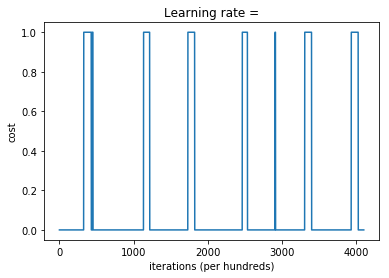

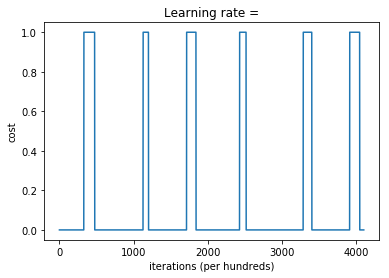

In [230]:

plt.plot(np.squeeze(simulation_inside["Y_prediction_test"]))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =")
plt.show()

plt.plot(np.squeeze(y_inside_array))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =")
plt.show()


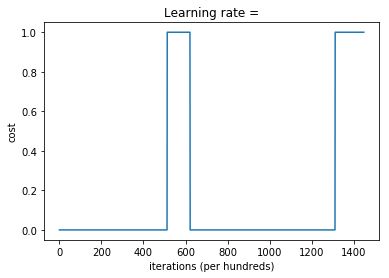

In [215]:

plt.plot(np.squeeze(simulation_grass["Y_prediction_test"]))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =")
plt.show()


In [216]:
x = np.squeeze(simulation_square["Y_prediction_test"])
y = np.squeeze(y_square_array)
for i in range(2028, x.shape[0]):
    if x[i] == 0:
        print(i)
        break
print(x[639])

2028
1.0


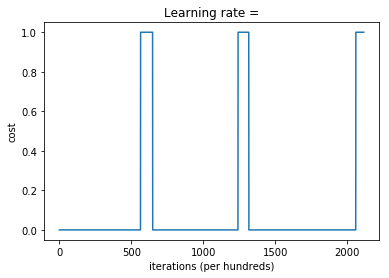

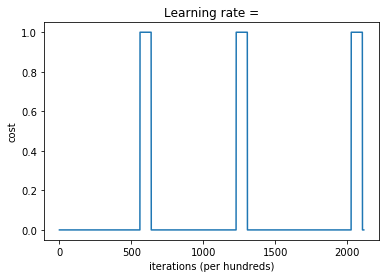

In [220]:

plt.plot(np.squeeze(simulation_square["Y_prediction_test"]))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =")
plt.show()


plt.plot(np.squeeze(y_square_array))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =")
plt.show()


In [221]:
X_train, X_test, Y_train, Y_test = cross_validation(grass_array,y_grass_array, 4, 6)

NameError: name 'grass_array' is not defined

In [222]:
cross_validation = model(X_train, 
           Y_train,X_test, Y_test, 
            num_iterations=2000, learning_rate= 0.8, print_cost= True)
y_prediction_cross_validation_01 = cross_validation["Y_prediction_test"]

NameError: name 'X_train' is not defined

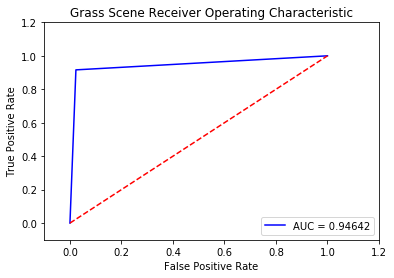

In [223]:
predictions = np.squeeze(simulation_grass["Y_prediction_test"])
actual = np.squeeze(y_grass_array)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Grass Scene Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
            label='AUC = %0.5f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


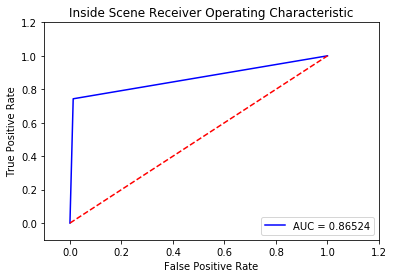

In [231]:
predictions = np.squeeze(simulation_inside["Y_prediction_test"])
actual = np.squeeze(y_inside_array)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Inside Scene Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
            label='AUC = %0.5f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


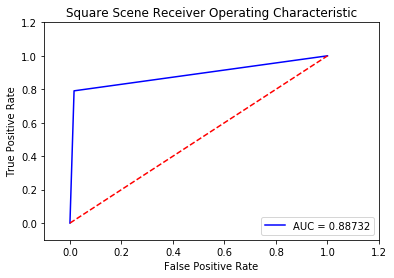

In [224]:
predictions = np.squeeze(simulation_square["Y_prediction_test"])
actual = np.squeeze(y_square_array)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Square Scene Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
            label='AUC = %0.5f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [158]:
handleEndScene(506,grass_smoothed_array,609)

finish_point is 617


ValueError: cannot slice a 0-d array

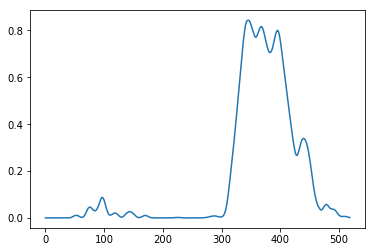

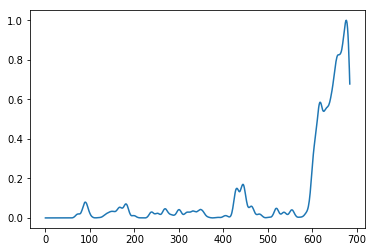

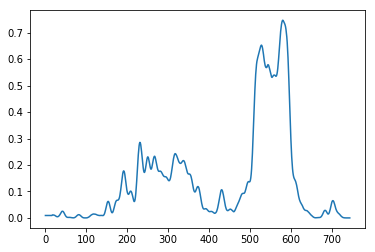

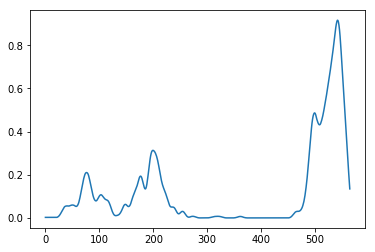

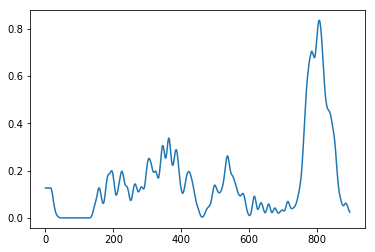

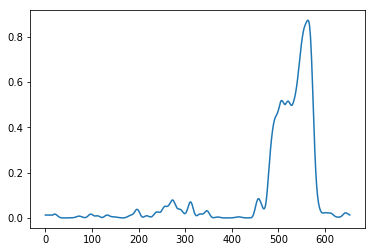

In [145]:
for i in range(3,9):
    if i == 0:
        continue
    else:
        
        plt.plot(np.squeeze(feature_smoothed[i]))
        plt.show()
